# Analyze background heat flow in the Alps 

Load background heat flow data from the SMU heat flow database. Use kriging to make a map and calculate background heat flux for the different orogens in North America.

## Import modules:

In [1]:
import itertools
import os
import subprocess
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import pandas as pd
import geopandas as gp

import shapely
import rasterio as rio

import cartopy.crs as ccrs

#import pykrige.kriging_tools as kt
#from pykrige.ok import OrdinaryKriging

import lib.mapping_functions as mf

import earthpy.spatial as es

import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from mpl_toolkits.axes_grid.inset_locator import inset_axes
from matplotlib.patches import Rectangle

pl.rcParams['mathtext.default'] = 'regular'

/home/elco/python_scripts/thermal_springs_alps/lib/mapping_functions.py:10: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


## Define some variables:

In [2]:
fnb = 'GIS_data/ne_10m_geography_regions_polys.shp'

fnr = "/home/elco/GIS/global/elevation/etopo/ETOPO1_Bed_g_geotiff.tif"

hf_data_file = 'data/heat_flow_NA_merged.csv'
hf_column = 'heat_flow'
xcol = 'longitude'
ycol = 'latitude'

#gradient_col = 'geoth_grad'

#alps_bnd_buffer = 0.01

#extent = [-170, -60, 30, 70]
extent = xmin, xmax, ymin, ymax = [-170, -50, 20, 75]

vlims = [[25.0, 150.0], [25.0, 150.0]]
class_ints = [5.0, 2.5]
panel_labels = [['a', ''], ['b', '']]
zlabels = [r'Heat flow density ($\times 10^{-3} W m^{-2}$)', 
           r'Heat flow density ($\times 10^{-3} W m^{-2}$)']
#zlabels_short = ['heat flow', 'temp gradient']
fns_out = ['fig/background_heat_flow_map_NA.svg', 
           'fig/background_heat_flow_map_NA_raster.svg']

drape_images = [None, 'GIS_data/heat_flow_NA_nat_neighbour.tif']
#drape_images = [None, 'GIS_data/heat_flow_NA_ord_kriging.tif']

#xmin, xmax, ymin, ymax = (4.0, 18.0, 42.75, 49.0)

cmap = matplotlib.cm.get_cmap('coolwarm')

proj = ccrs.PlateCarree()

fs_legend = 'small'
label_fs = 'medium'

legend_label = 'Data'
legend_label_nd = 'No data'

hist_ylabel = 'Number of\ndata points'

## Read the heat flow data

In [3]:
df = pd.read_csv(hf_data_file)

print('number of heat flow datapoints = %i' % (len(df)))

df.loc[df[hf_column]==0.0, hf_column] = np.nan
df.loc[df[hf_column]==-99999.0, hf_column] = np.nan

df = df.dropna(subset=[xcol, ycol, hf_column])

print('number of heat flow datapoints = %i' % (len(df)))

df.head()

number of heat flow datapoints = 61753
number of heat flow datapoints = 61753


,Unnamed: 0,longitude,latitude,heat_flow,geometry
0,20,-87.134000,30.458800,55.0,POINT (-87.134 30.4588)
1,46,-82.023200,37.380100,81.0,POINT (-82.0232 37.3801)
2,105,-117.648213,43.966163,41.8,POINT (-117.6482134 43.96616289999999)
3,126,-96.055600,31.676800,71.0,POINT (-96.0556 31.6768)
4,129,-79.159900,42.186500,48.3,POINT (-79.15989999999999 42.1865)


## Convert to geopandas dataframe for easier spatial processing

In [4]:
df['geometry'] = df.apply(lambda z: shapely.geometry.Point(z[xcol], z[ycol]), axis=1)
dg = gp.GeoDataFrame(df)

In [5]:
#dg = dg.set_crs("EPSG:4326")
dg.crs = {'init' : 'epsg:4326'}

## Read shapefile with areas

In [6]:
da = gp.read_file(fnb)
#alps_poly = dgb.buffer(alps_bnd_buffer).geometry[0]
#alps_poly

## Convert HF DB to UTM32N to calculate heat flow density

In [7]:
# us national atlas equal area projection = espg 2163

#dgu = dg.to_crs({'init': 'epsg:2163'})
#dgu = dg.to_crs("EPSG:2163")

## 

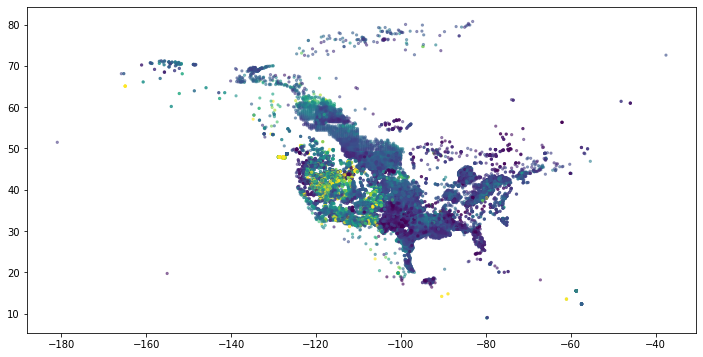

In [8]:
fig, ax = pl.subplots(1,1, figsize=(12, 6))
ax.scatter(dg[xcol], dg[ycol], c=dg[hf_column], vmin=20, vmax=150, s=5, alpha=0.5)

## Get statistics for heat flow for orogens

In [9]:
areas = ['APPALACHIAN MTS.', 'CASCADE RANGE', 
         'COAST MOUNTAINS', 'COAST RANGES',
         'MACKENZIE MTS.', 'ROCKY MOUNTAINS', 'SIERRA NEVADA',]

area_labels = ['Appalachians', 'Cascades', 
               'Coastal Mts.', 'Coastal ranges', 
               'Mackenzie Mts.', 'Rocky Mts', 'Sierra Nevada']

area_labels_short = ['AP',
                     'CA', 'CM', 'CR', 
                     'MK', 'RM', 'SN']

In [10]:
cols = ['background_heat_flow']

dri = pd.DataFrame(index=areas, columns=cols)

dri['area_name'] = area_labels

dri['area_name_short'] = area_labels_short

dr = gp.GeoDataFrame(dri)

In [11]:
for area in areas[:]:
    
    print(area)
    
    ind = da['name'] == area
    #print(da.loc[ind])
    dai = da.loc[ind]
 
    print('selecting datapoints in bbox')
    x1, y1, x2, y2 = dai.iloc[0].geometry.bounds
    in_bbox = (dg[xcol] >= x1) & (dg[xcol] < x2) & (dg[ycol] > y1) & (dg[ycol] < y2)
    dgb = dg.loc[in_bbox]
    
    print('selecting datapoints in polygon')
    # select_springs in polygon
    in_polygon = [dai.contains(dsgi).values[0] for dsgi in dgb.geometry.values]
    ds = dgb.loc[in_polygon]
    
    avg_HF = ds[hf_column].mean()
    
    print('%s, average heat flow = %0.02f, n datapoints = %i' % (area, avg_HF, len(ds)))
    

APPALACHIAN MTS.
selecting datapoints in bbox
selecting datapoints in polygon
APPALACHIAN MTS., average heat flow = 52.56, n datapoints = 12011
CASCADE RANGE
selecting datapoints in bbox
selecting datapoints in polygon
CASCADE RANGE, average heat flow = 222.98, n datapoints = 780
COAST MOUNTAINS
selecting datapoints in bbox
selecting datapoints in polygon
COAST MOUNTAINS, average heat flow = 228.16, n datapoints = 57
COAST RANGES
selecting datapoints in bbox
selecting datapoints in polygon
COAST RANGES, average heat flow = 180.72, n datapoints = 561
MACKENZIE MTS.
selecting datapoints in bbox
selecting datapoints in polygon
MACKENZIE MTS., average heat flow = 79.34, n datapoints = 73
ROCKY MOUNTAINS
selecting datapoints in bbox
selecting datapoints in polygon
ROCKY MOUNTAINS, average heat flow = 220.09, n datapoints = 2741
SIERRA NEVADA
selecting datapoints in bbox
selecting datapoints in polygon
SIERRA NEVADA, average heat flow = 216.07, n datapoints = 80


## Load DEM

In [12]:
def read_raster(fnr):

    rf = rio.open(fnr)
    raster = rf.read()[0]
    
    nodata = rf.nodata

    raster = raster[::-1]

    bounds = rf.bounds
    xres, yres = rf.res

    rf.close()

    xcoords = np.arange(bounds.left + xres/2., bounds.right + xres/2., xres)
    ycoords = np.arange(bounds.bottom + yres/2., bounds.top + yres/2., yres)
    x_raster, y_raster = np.meshgrid(xcoords, ycoords)
    
    #raster[raster==nodata] = np.nan

    return x_raster, y_raster, xcoords, ycoords, raster

In [13]:
x_raster, y_raster, xcoords, ycoords, dem = read_raster(fnr)

res = 10
x_raster = x_raster[::res, ::res]
y_raster = y_raster[::res, ::res]
dem = dem[::res, ::res]
xcoords = xcoords[::res]
ycoords = ycoords[::res]

In [14]:


def make_map_figure(proj, extent, panel_labels,
                    x_raster, y_raster, dem, 
                    x, y, z, vlim, class_int,
                    zlabel, hist_ylabel, legend_label, legend_label_nd, 
                    shps, shp_colors, shp_ls, shp_lws,
                    dem_min=-1000, dem_max=5000,
                    cmap='coolwarm',
                    long_ticks=None, 
                    lat_ticks=None,
                    fs_legend='small',
                    mark_highest_value=True,
                    n_highest=2,
                    add_histo=True,
                    histo_loc='lower right',
                    add_inset_background=False,
                    return_ax=False, s=40,
                    cmap_hs='Greys',
                    hs_azimuth=270,
                    hs_altitude=30,
                    use_earthpy=False,
                    drape_image=None):
    
    vmin, vmax = vlim
    
    fig = pl.figure(figsize=(10, 6))
    panel = fig.add_subplot(1, 1, 1, projection=proj)
    
    xmin, xmax, ymin, ymax = extent
    
    panel.set_extent([xmin, xmax, ymin, ymax], crs=proj) 
    
    # calculate hillshade colors
    print('calculating hillshade')
    
    if use_earthpy is False:
        
        rgb = mf.set_shade(dem, cmap=matplotlib.cm.Greys_r, vmin=dem_min, vmax=dem_max)

        # correct rgb array. not really sure why but otherwise the image isnt correct
        rgb = rgb[:, :-1, :]

        # convert rgb to tuple
        color_tuple = np.array([rii for ri in rgb for rii in ri])
        color_tuple = np.insert(color_tuple, 3, 1.0, axis=1)
        #dem[dem <= 0 ] = np.nan
        im = panel.pcolormesh(x_raster, y_raster, dem, 
                              color=color_tuple, transform=proj, zorder=1, rasterized=True)
    else:
        hillshade = es.hillshade(dem, altitude=hs_altitude, azimuth=hs_azimuth)

        print('creating color image')
        #dem[dem <= 0 ] = np.nan
        #im = panel.pcolormesh(x_raster, y_raster, dem, 
        #                      color=color_tuple, transform=proj, zorder=1, rasterized=True)
        
        
        if drape_image is not None:
            
            print('adding drape image')
            xd, yd, rd = drape_image
            
            im = panel.pcolormesh(xd, yd, rd, cmap=cmap, 
                                  transform=proj, zorder=1, 
                                  vmin=vmin, vmax=vmax, rasterized=True) #rasterized=True,             
            imh = panel.pcolormesh(x_raster, y_raster, hillshade, cmap=cmap_hs, 
                                  transform=proj, zorder=1, rasterized=True, alpha=0.1) #
            
    # plot additional shapefiles
    if shps is not None:
        for shp, shp_color, shp_lsi, shp_lw in zip(shps, shp_colors, shp_ls, shp_lws):
            panel.add_geometries(shp.geometry, crs=proj, facecolor='none', 
                                 edgecolor=shp_color, ls=shp_lsi, lw=shp_lw)
    
    
    
    if z is not None:
        ind = np.isnan(z)
        leg_springs_nd = panel.scatter(x[ind], y[ind],
                                       vmin=vmin, vmax=vmax, zorder=102, s=s, marker='o',
                                       facecolor='None', edgecolor='black', transform=proj,
                                      rasterized=True)

        ind = np.isnan(z) == False
        leg_springs = panel.scatter(x[ind], y[ind], c=z[ind],
                                    vmin=vmin, vmax=vmax, zorder=103, s=s, marker='o',
                                    cmap=cmap, facecolor='none', transform=proj, lw=1.5,
                                   rasterized=True)

        leg_springs.set_facecolor('none')

        if mark_highest_value is True:
            #indh = np.argmax(z[ind])
            indh = z[ind].argsort()[-n_highest:][::-1]

            xs = x[ind][indh]
            ys = y[ind][indh]
            zs = z[ind][indh]

            leg_highest = panel.scatter(xs, ys, c=zs,
                                    vmin=vmin, vmax=vmax, zorder=104, s=150, marker='*',
                                    cmap=cmap, facecolor='none', transform=proj, lw=1.5)

            maxcol = cmap(1.0)

            if (len(xs) == 2) & (xs[1] == xs[0]) & (ys[1] == ys[0]):
                tekst = '1,2'
                panel.text(xs[0], ys[0] + 0.15, tekst, 
                           va='bottom', ha='center', 
                           weight='bold', transform=proj, fontsize='xx-large', 
                           zorder=105, color=maxcol)

            else:
                for j, xi, yi in zip(itertools.count(), xs, ys):
                    print('tekst: ', j, xi, yi + 0.1)
                    panel.text(xi, yi + 0.15, '%s' % (j+1), 
                               va='bottom', ha='center', weight='bold', 
                               transform=proj, fontsize='xx-large', zorder=105, color=maxcol)

            print(xs, ys, [z[ind][indh]])
    
    else:
        leg_springs = None
        
    #panel.coastlines('50m')
    #panel.add_feature(cfeature.OCEAN(scale='50m'), zorder=101)
    sea_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                            edgecolor='face',
                                            facecolor='lightblue', zorder=101)
    panel.add_feature(sea_50m)
    
    if long_ticks is not None and lat_ticks is not None:
        gl = panel.gridlines(xlocs=long_ticks, 
                             ylocs=lat_ticks,
                             crs=proj, zorder=2001, linestyle=':', 
                             draw_labels=True)
    else:
        gl = panel.gridlines(crs=proj, zorder=2001, linestyle=':', 
                             draw_labels=True)
        

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False

    panel.set_xlabel('Longitude')
    panel.set_ylabel('Latitude')
    
    if drape_image is None:
        legs = [leg_springs, leg_springs_nd]
        labels = [legend_label, legend_label_nd]

        #legend = panel.legend(legs, labels,fancybox=True, framealpha=0.75)
        #legend.legendPatch.set_facecolor('wheat')

        cb = fig.colorbar(leg_springs, shrink=0.3)
        cb.set_label(zlabel)
    else:
        cb = fig.colorbar(im, shrink=0.3)
        cb.set_label(zlabel)
        
    
    ##################################
    # add inset panel with histogram:
    #################################
    if add_histo == True:
        inset_panel = inset_axes(panel,
                                 width="20%",  # width = 30% of parent_bbox
                                 height="25%",  # height : 1 inch
                                 loc=histo_loc, borderpad=3.5)

        inset_panel.tick_params(axis='both', which='major', labelsize=fs_legend)
        inset_panel.tick_params(axis='both', which='minor', labelsize=fs_legend)
        inset_panel.grid(b=False)

        bins = np.arange(vmin, vmax + class_int, class_int)
        freq, bins = np.histogram(z, bins=bins)

        bins_norm = (bins - vmin) / (vmax - vmin)

        bins_norm[bins_norm < 0.0] = 0.0
        bins_norm[bins_norm > 1.0] = 1.0
        color_vals = bins_norm

        #cmap = matplotlib.cm.get_cmap('GnBu')
        colors = cmap(color_vals[:-1])
        widths = bins[1:] - bins[:-1]
        inset_panel.bar(bins[:-1] + widths/2.0, freq,
                        width=widths, color=colors, edgecolor=colors, linewidth=0)
        
        if add_inset_background is True:
            inset_panel.set_facecolor('lightgrey')
            #inset_panel.set_axis_bgcolor("lightgrey")
            #inset_panel.set_clip_on(False)

        #inset_panel.patch.set_alpha(0.75)
        #fig.tight_layout()
        inset_panel.set_xlabel(zlabel)
        inset_panel.set_ylabel(hist_ylabel)
        inset_panel.text(0.02, 1.03, panel_labels[1], weight='bold', 
                         fontsize=fs_legend, transform=inset_panel.transAxes)
        tekst = 'n=%i' % (len(z[np.isnan(z)==False]))
        inset_panel.text(0.98, 0.98, tekst, ha='right', va='top', transform=inset_panel.transAxes, fontsize=fs_legend)

        from matplotlib.patches import Rectangle
        bb = inset_panel.get_tightbbox(fig.canvas.get_renderer())
        #r = Rectangle(bb.bounds[:2], bb.bounds[2], bb.bounds[3], color='lightgrey', zorder=100)
        r = Rectangle((12.6, ymin), 7, 3.0, color='lightgrey', zorder=102, alpha=0.5)
        panel.add_patch(r)
    
    panel.text(0.00, 1.03, panel_labels[0], 
               fontsize=fs_legend,  weight='bold', transform=panel.transAxes)
    
    fig.tight_layout()
    
    if return_ax is True:
        return fig, panel
    else:
        return fig

## Make a figure

In [15]:
## Load shapefile with orogen shapes
fns = 'GIS_data/ne_10m_geography_regions_polys.shp'

da = gp.read_file(fns)

areas = ['Alps', 'APPALACHIAN MTS.', 'CASCADE RANGE', 
         'COAST MOUNTAINS', 'COAST RANGES',
         'MACKENZIE MTS.', 'ROCKY MOUNTAINS', 'SIERRA NEVADA',]

area_labels = ['Alps', 'Appalachians', 'Cascades', 
               'Coastal Mts.', 'Coastal ranges', 
               'Mackenzie Mts.', 'Rocky Mts', 'Sierra Nevada']

area_labels_short = ['AL', 'AP',
                     'CA', 'CM', 'CR', 
                     'MK', 'RM', 'SN']

calculating hillshade


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:214: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


Alps AL
APPALACHIAN MTS. AP
CASCADE RANGE CA
COAST MOUNTAINS CM
COAST RANGES CR
MACKENZIE MTS. MK
ROCKY MOUNTAINS RM
SIERRA NEVADA SN
saving map as fig/background_heat_flow_map_NA.svg
done
reading raster file GIS_data/heat_flow_NA_nat_neighbour.tif
calculating hillshade
creating color image
adding drape image
Alps AL
APPALACHIAN MTS. AP
CASCADE RANGE CA
COAST MOUNTAINS CM
COAST RANGES CR
MACKENZIE MTS. MK
ROCKY MOUNTAINS RM
SIERRA NEVADA SN
saving map as fig/background_heat_flow_map_NA_raster.svg
done


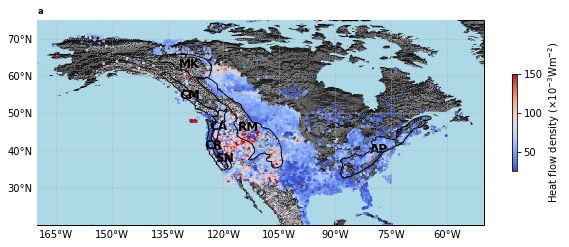

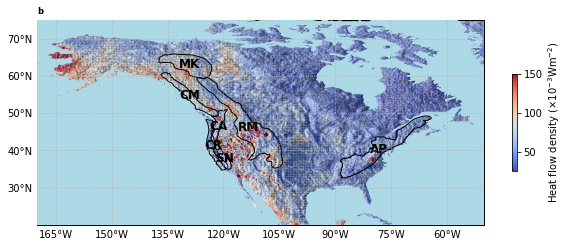

In [16]:
use_earthpys = [False, True]

xs = [dg[xcol].values, None]
ys = [dg[ycol].values, None]
zs = [dg[hf_column].values, None]

extent = xmin, xmax, ymin, ymax   

x1 = np.where(xcoords > xmin)[0][0]
x2 = np.where(xcoords < xmax)[0][-1]
y1 = np.where(ycoords > ymin)[0][0]
y2 = np.where(ycoords < ymax)[0][-1]

shps, shp_colors, shp_lss, shp_lws = None, None, None, None

for xi, yi, zi, vlim, class_int, panel_label, zlabel, drape_image, use_earthpy, fn_out \
    in zip(xs, ys, zs, 
           vlims, class_ints, panel_labels, 
           zlabels, drape_images, use_earthpys, fns_out):
    
    if drape_image is not None:
        print('reading raster file %s' % drape_image)
        xd, yd, xcd, ycd, di = read_raster(drape_image)
        
        drape_image = [xd, yd, di]
    
    fig = make_map_figure(proj, extent, panel_label,
                          x_raster[y1:y2,x1:x2], y_raster[y1:y2,x1:x2], dem[y1:y2,x1:x2], 
                          xi, yi, zi, vlim, class_int,
                          zlabel, hist_ylabel, legend_label, legend_label_nd, 
                          shps, shp_colors, shp_lss, shp_lws, mark_highest_value=False, 
                          add_histo=False,
                          s=1, cmap_hs='gray', hs_altitude=10,
                          drape_image=drape_image, use_earthpy=use_earthpy)
    
    ax = pl.gca()
    
    # add orogen locations:
    for area_i, area, short_label in zip(itertools.count(), areas, area_labels_short):

        print(area, short_label)

        ind = da['name'] == area
        #print(da.loc[ind])
        dai = da.loc[ind]

        if area in da['name'].values:

            #dai.plot(ax=ax, color='gray')
            ax.add_geometries(dai['geometry'], 
                              facecolor='none', edgecolor='black', 
                              crs=proj, zorder=200)

            d = dai['geometry'].centroid.values[0]
            c = d.coords[:][0]
            ax.text(c[0], c[1], short_label, fontsize='large', color='black',
                        va='center', ha='center', transform=proj, weight='bold', zorder=202)
    
    fig.tight_layout()
    
    #fn_out = 'fig/background_heat_flow_map.png'
    print('saving map as %s' % fn_out)
    fig.savefig(fn_out, dpi=200)
    print('done')

In [17]:
print('combining figure panels:')

#sgd_script_loc = '/home/elco/python_modules/svg_stack.py'
merge_script_loc = 'lib/svg_stack.py'


fn_combs = 'fig/map_HF_NA_combined.svg'

cwd = os.getcwd()

call_command = ['python', merge_script_loc, '--direction=v']
call_command += [os.path.join(cwd, fn) for fn in fns_out]
call_command += [os.path.join(cwd, fn_combs)]
print(call_command)
subprocess.call(call_command)
print('merged ', fns_out)
print('and saved as %s' % fn_combs)

combining figure panels:
['python', 'lib/svg_stack.py', '--direction=v', '/home/elco/python_scripts/thermal_springs_alps/fig/background_heat_flow_map_NA.svg', '/home/elco/python_scripts/thermal_springs_alps/fig/background_heat_flow_map_NA_raster.svg', '/home/elco/python_scripts/thermal_springs_alps/fig/map_HF_NA_combined.svg']
merged  ['fig/background_heat_flow_map_NA.svg', 'fig/background_heat_flow_map_NA_raster.svg']
and saved as fig/map_HF_NA_combined.svg
